In [1]:
import os
os.chdir('..')

In [2]:
import torch
import numpy as np

from instance_generator import sample_instances
from gnn_library.util import train, save, load, gen_train_input
from evaluate import evaluate_model
from params import *
from util import upload_meta_experiment, load_meta_experiments, \
    graph_config_to_string, _plot_meta_ratios

%load_ext autoreload
%autoreload 2

device = torch.device('cuda:7' if torch.cuda.is_available() else 'cpu')
print("PyTorch has version {}".format(torch.__version__))
print('Using device:', device)

PyTorch has version 2.0.0+cu117
Using device: cuda:7


## Train meta-GNN

In [3]:
GNN1, args1 = load('GNN1_hyperparam_tuned', device)
GNN2, args2 = load('GNN2_hyperparam_tuned', device)

In [ ]:
args = {
    'processor':         'DeeperGCN',
    'head':              'meta',
    'num_layers':        4,
    'num_mlp_layers':    2,
    'aggr':              'max',
    'batch_size':        6,
    'node_feature_dim':  7,
    'edge_feature_dim':  1,
    'graph_feature_dim': 2,
    'hidden_dim':        8,
    'output_dim':        2,
    'head_mlp_dim':      8,
    'dropout':           0,
    'epochs':            35,
    'opt':               'adam',
    'opt_scheduler':     'none',
    'opt_restart':       0,
    'weight_decay':      5e-3,
    'lr':                0.001,
    'device':            device
}

train_loader, val_loader = gen_train_input(META_TRAIN_CONFIG, args, seed=0, base_models=[GNN1, GNN2])
_, _, _, META_GNN, _ = train(train_loader, val_loader, args)
save(META_GNN, args, 'META_GNN')


## Regime generalization experiment

#### Compute meta-GNN CRs over all graph configurations and node ratio regimes

In [4]:
META_GNN, args = load('META_GNN', device)

In [11]:
seed = 0
rng = np.random.default_rng(seed)
num_trials = 50#100
batch_size = 100
graph_configs = ALL_TESTING_GRAPH_CONFIGS[1:2]
node_configs = [(30, 10)] #EXPERIMENT_META_REGIMES[:2]
baselines_kwargs = {
    'greedy': {},
    'greedy_t': {'threshold': 0.35},
    'lp_rounding': {'rng': rng},
    'naor_lp_rounding': {'rng': rng}
}

regimes = [x/y for (x,y) in node_configs]

def _init_data():
    return {
        "num_trials": num_trials,
        "meta_gnn": [],
        "greedy": [],
        "greedy_t": [],
        "lp_rounding": [],
        "naor_lp_rounding": [],
        "meta_threshold": []
    }

for graph_config in graph_configs:
    data = _init_data()
    graph_str = graph_config_to_string(graph_config)

    for i, node_config in enumerate(node_configs):
        print(graph_config, node_config)
        instances = sample_instances(
            *node_config,
            num_trials,
            rng,
            args.__dict__,
            **graph_config
        )

        rng = np.random.default_rng(seed)
        crs, _ = evaluate_model(
            meta_model=None,
            meta_model_type='gnn',
            base_models=[GNN2],
            instances=instances,
            batch_size=batch_size,
            rng=rng,
            num_realizations=5,
            baselines=['greedy', 'greedy_t', 'lp_rounding', 'naor_lp_rounding'],
            **baselines_kwargs
        )
        
        # rng = np.random.default_rng(seed)
        # threshold_crs, _ = evaluate_model(
        #     meta_model=None,
        #     meta_model_type='threshold',
        #     base_models=[GNN1, GNN2],
        #     instances=instances,
        #     batch_size=batch_size,
        #     rng=rng,
        #     num_realizations=5
        # )

        data['meta_gnn'].append(crs['learned'])
        data['greedy'].append(crs['greedy'])
        data['greedy_t'].append(crs['greedy_t'])
        data['lp_rounding'].append(crs['lp_rounding'])
        data['naor_lp_rounding'].append(crs['naor_lp_rounding'])
        # data['meta_threshold'].append(threshold_crs['learned'])
    
    upload_meta_experiment(graph_str, data)

{'graph_type': 'ER', 'p': 0.5, 'weighted': True} (30, 10)
Set parameter TokenServer to value "soal-nas.stanford.edu"
Set parameter TokenServer to value "soal-nas.stanford.edu"
Set parameter TokenServer to value "soal-nas.stanford.edu"
Set parameter TokenServer to value "soal-nas.stanford.edu"
Set parameter TokenServer to value "soal-nas.stanford.edu"
Set parameter TokenServer to value "soal-nas.stanford.edu"
Set parameter TokenServer to value "soal-nas.stanford.edu"
Set parameter TokenServer to value "soal-nas.stanford.edu"
Set parameter TokenServer to value "soal-nas.stanford.edu"
Set parameter TokenServer to value "soal-nas.stanford.edu"
Set parameter TokenServer to value "soal-nas.stanford.edu"
Set parameter TokenServer to value "soal-nas.stanford.edu"
Set parameter TokenServer to value "soal-nas.stanford.edu"
Set parameter TokenServer to value "soal-nas.stanford.edu"
Set parameter TokenServer to value "soal-nas.stanford.edu"
Set parameter TokenServer to value "soal-nas.stanford.edu

In [12]:
for key in data.keys():
    if key != 'num_trials' and key != 'meta_threshold':
        print(key, np.mean(data[key]))

meta_gnn 0.9279833390197161
greedy 0.828318822255999
greedy_t 0.8758674597095005
lp_rounding 0.9287539827432307
naor_lp_rounding 0.9179439771209859


#### Generate regime generalization plots

KeyError: 'meta_gnn'

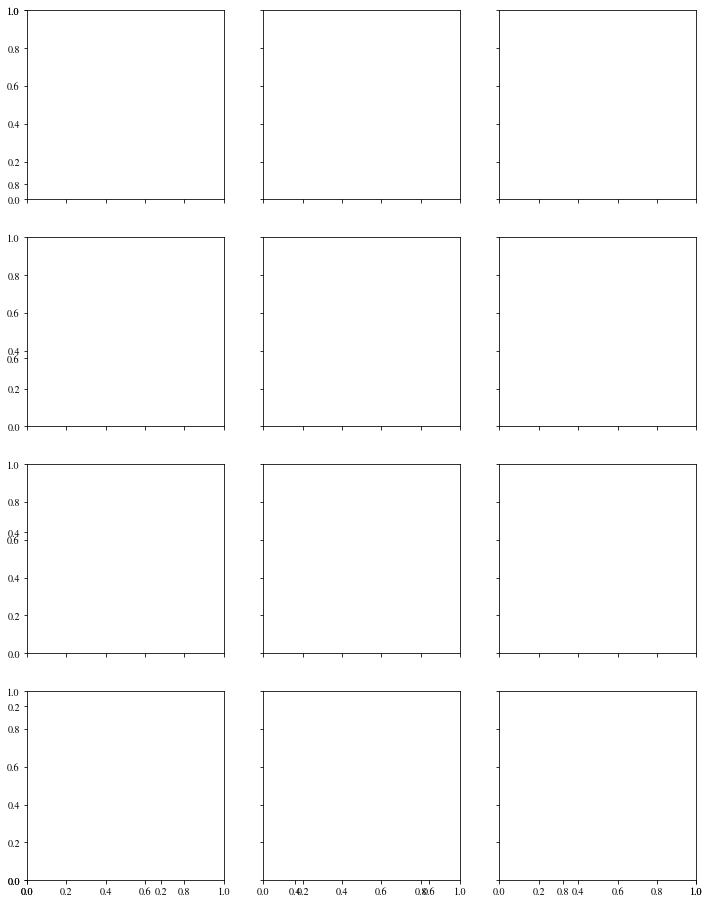

In [12]:
results = load_meta_experiments(ALL_TESTING_GRAPH_CONFIGS)
_plot_meta_ratios(
    regimes,
    results,
    ['meta_gnn', 'greedy', 'greedy_t', 'lp_rounding', 'naor_lp_rounding'],
    lambda graph_type: graph_type,
    confidence = 0.95
)

In [ ]:
data = load_meta_experiments(graph_configs)